In [3]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Image Processing/lez11_Inpainting_and_Spark')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Image Processing/lez11_Inpainting_and_Spark'

Load the image and rescale it in $[0,1]$

In [6]:
img = imread(f'./data/cameraman.png') / 255
img = img[50:200,50:200]

imsz = img.shape

# patch size
p = 7

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 12

Corrupt the image with white gaussian noise

In [7]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise

Compute the psnr of the noisy input

In [8]:
MSE = ((img - noisy_img)**2).mean()
psnr_noisy = 10 * np.log10(1/MSE)

Text(0.5, 1.0, 'Noisy image, PSNR = 22.10')

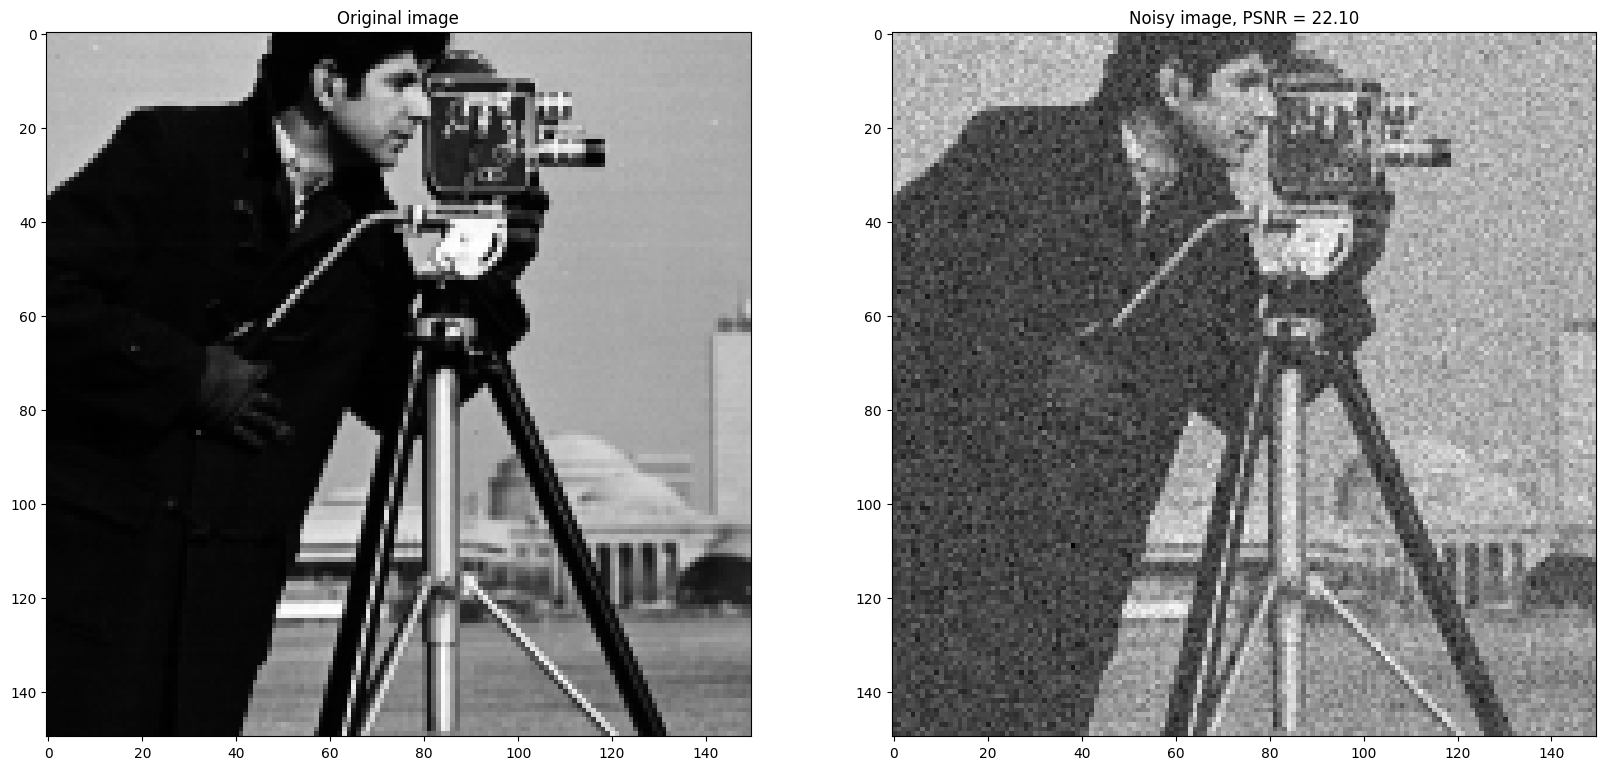

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [10]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
hp = p // 2
img_pad = np.pad(noisy_img, hp, mode="symmetric")

Main loop

In [11]:
for i in range(0, imsz[0]):
    for j in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[i:i+p, j:j+p]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for r in range(max(0, i - H), min(imsz[0], i + H + 1)):
            for c in range(max(0, j - H), min(imsz[1], j + H + 1)):
                # extract the patch
                z = img_pad[r:r+p,c:c+p]

                # compute the distance with the reference patch
                d = np.linalg.norm(s - z, ord=2)**2

                # update the weight and the pixel estimate
                w = np.exp(-d/(M*sigma_noise**2))
                pixel_hat += w * z[hp,hp] # extract the centered pixel
                weight += w
                
        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat / weight      


Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 27.39')

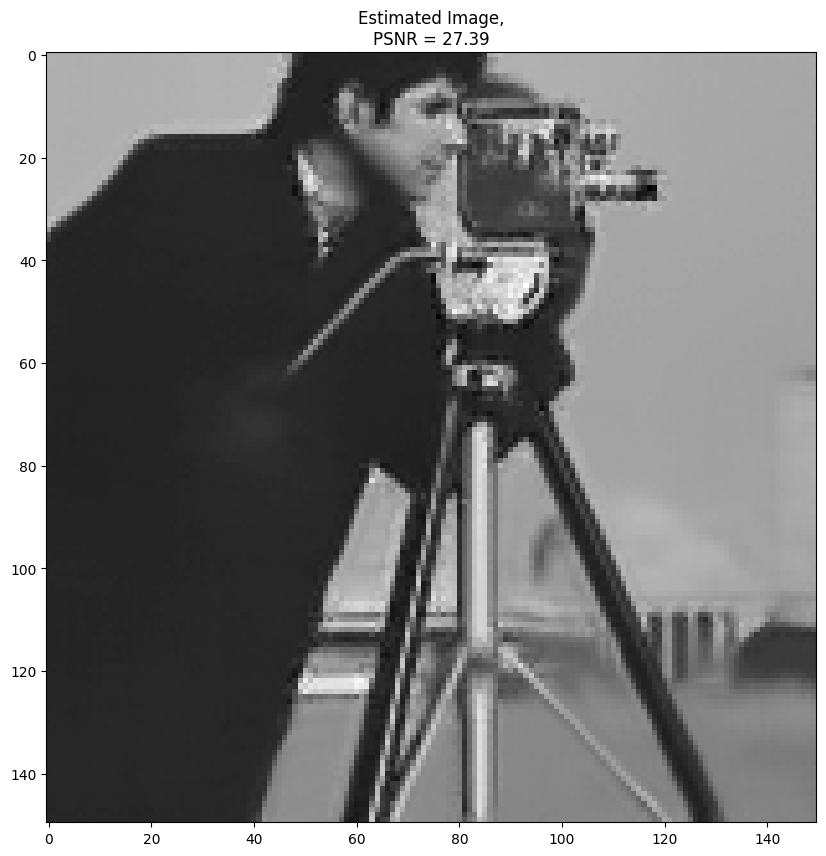

In [12]:
MSE = ((img - img_hat)**2).mean()
psnr_hat = 10 * np.log10(1/MSE)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
